# Imports

In [34]:
import pandas as pd

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap
from sklearn import metrics
from sklearn.metrics import accuracy_score 
import plot_utils
from statistics import mean 

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Read Data Set

In [35]:
df = pd.read_csv("mergeData_fixed_time.csv")
df = df.drop('total_time', axis=1) 
pd.options.display.max_columns = None
df.head()

,pedId,speed_total_mean,steering_total_mean,brake_total_mean,throttle_total_mean,acceleration_total_mean,speed_total_var,steering_total_var,brake_total_var,throttle_total_var,acceleration_total_var,distancePed,max_speed,PKE,PKE_Steering,speed_react,reaction_time,pedestriansLevel,visibilityLevel,trafficLevel,gender,age,job,LatestDegree,oftenDrive,accidents,yearsDriving,lastDrive(years),speedingTickets,hadCollision
0,1.0,6.978462,0.493644,0.947244,0.813465,-0.000623,13.607109,0.000420,0.021339,0.032907,0.050404,68.920520,11.669766,1.110623,-0.000432,7.754880,1.048791,0,1,0,0,32,0,0,2,0,10,1.0,0,0
1,3.0,7.045599,0.504890,0.875541,0.911211,-0.045255,33.663919,0.000176,0.065360,0.002429,0.068962,69.359540,13.499710,0.084626,0.000000,13.472353,2.106615,0,1,0,0,32,0,0,2,0,10,1.0,0,0
2,15.0,10.263041,0.478319,0.817679,0.595013,-0.017068,76.873997,0.001610,0.105119,0.076302,0.705761,96.885284,25.851397,5.246326,0.000170,25.585112,0.079211,0,1,0,0,32,0,0,2,0,10,1.0,0,1
3,2.0,11.669419,0.500661,0.891913,0.522365,0.008028,47.209285,0.000396,0.055982,0.112551,0.159198,88.011610,20.055070,2.969647,-0.000258,19.412087,1.161592,2,1,0,0,32,0,0,2,0,10,1.0,0,0
4,4.0,12.187044,0.499769,0.861132,0.558120,0.001881,42.031423,0.000430,0.102442,0.079023,0.158822,105.973686,19.697004,4.033468,0.000066,18.461056,1.275896,2,1,0,0,32,0,0,2,0,10,1.0,0,0


### Distribution of cases

In [36]:
num_obs = len(df)
num_true = len(df.loc[df['hadCollision'] == 1])
num_false = len(df.loc[df['hadCollision'] == 0])
print("Number of True cases:  {0} ({1:2.2f}%)".format(num_true, (num_true/num_obs) * 100))
print("Number of False cases: {0} ({1:2.2f}%)".format(num_false, (num_false/num_obs) * 100))

Number of True cases:  37 (7.60%)
Number of False cases: 450 (92.40%)


We have considerably more false cases than true ones.

# Predictions

First I will start with the DecisionTree that made the feature importances plot.

### Auxiliar function for random repeats

In [4]:
from sklearn.model_selection import train_test_split
data = df.copy()
X = data.drop('hadCollision', axis=1) 
Y = data['hadCollision']

def default_train_test_split(test_size):
    return train_test_split(X, Y, test_size=test_size, stratify=Y)

def repite_model_predict_algorithm( fit_function, predict_function, repetitions=50, test_size=0.4, split_fuction=default_train_test_split):
    y_pred_total = []
    y_test_total = []
    for i in range(repetitions):
        X_train, X_test, y_train, y_test = split_fuction(test_size)
        fit_function(X_train, y_train)
        y_pred = predict_function(X_test)
        y_pred_total.append(y_pred)
        y_test_total.append(y_test)
    
    plot_utils.print_header("Multiple experiments average result:")
    summarize_multiple_experiments_average_results(y_test_total, y_pred_total)
    
    plot_utils.print_header("Sum of all experiments results:")
    summarize_one_big_experiment_results(y_test_total, y_pred_total)

def summarize_multiple_experiments_average_results(y_test_total, y_pred_total):
    total_acc, no_hit_prec, no_hit_rec, no_hit_fscore, hit_prec, hit_rec, hit_fscore, kappa = ([] for i in range(8))
    for y_true,y_pred in zip(y_test_total, y_pred_total):
        cr = metrics.classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        total_acc.append(cr['accuracy']*100)
        no_hit_prec.append(cr['0']['precision'])
        no_hit_rec.append(cr['0']['recall'])
        no_hit_fscore.append(cr['0']['f1-score'])
        hit_prec.append(cr['1']['precision'])
        hit_rec.append(cr['1']['recall'])
        hit_fscore.append(cr['1']['f1-score'])
        kappa.append(metrics.cohen_kappa_score(y_true, y_pred, labels=None, weights=None))
    print("Total Accuracy: %{0:.2f}".format(average(total_acc)))
    print("Cohen's kappa coefficient: {0:.2f}".format(average(kappa)))
    means = [[average(no_hit_prec), average(no_hit_rec), average(no_hit_fscore)], 
             [average(hit_prec), average(hit_rec), average(hit_fscore)]]
    plot_utils.plot_classification_report_means(means)
    plot_utils.plot_confusion_matrix([[average(no_hit_rec), 1 - average(no_hit_rec)],
                                      [1 - average(hit_rec), average(hit_rec)]])
    plot_utils.print_result(average(kappa))
    plot_utils.print_result(average(total_acc), 92.31, "Total Accuracy percentaje", '%')
    plot_utils.print_result(average(hit_prec), 0, "Hit Precision")
    plot_utils.print_result(average(hit_rec), 0, "Hit Recall")
    plot_utils.print_result(average(no_hit_prec), 0.92, "No Hit Precision")
    plot_utils.print_result(average(no_hit_rec), 1, "No Hit Recall")
    
def average(values):
    return round(mean(values), 2)
    
def summarize_one_big_experiment_results(y_test_total, y_pred_total):
    y_test_total = [val for sublist in y_test_total for val in sublist]
    y_pred_total = [val for sublist in y_pred_total for val in sublist]
    lookup = {0: 'No Hit', 1:'Yes Hit'}
    y_true_pd = pd.Series([lookup[_] for _ in y_test_total])
    y_pred_pd = pd.Series([lookup[_] for _ in y_pred_total])
    

    print("Confusion Matrix")
    print("")
    tab = pd.crosstab(y_true_pd, y_pred_pd, rownames=['True'], colnames=['Predicted'], margins=False)

    print(tab)
    print("")    

## Zero Rule Baseline (All No Recurrence)

<h3>Multiple experiments average result:</h3>

Total Accuracy: %92.31
Cohen's kappa coefficient: 0.00


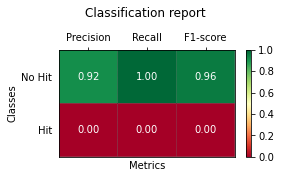

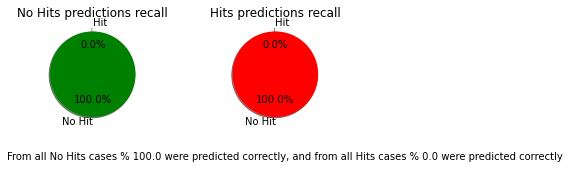

Cohen's kappa coefficient is same as the baseline:  0.0

Total Accuracy percentaje is same as the baseline: % 92.31

Hit Precision is same as the baseline:  0.0

Hit Recall is same as the baseline:  0.0

No Hit Precision is same as the baseline:  0.92

No Hit Recall is same as the baseline:  1.0

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit
True             
No Hit      18000
Yes Hit      1500



In [5]:
# zero rule algorithm for classification
def zero_rule_algorithm_fit(train, test):
    #DO NOTHING
    pass

def zero_rule_algorithm_classification(test):
    prediction = 0
    predicted = [prediction for i in range(len(test))]
    return predicted

repite_model_predict_algorithm(zero_rule_algorithm_fit, zero_rule_algorithm_classification, 100, 0.4)

## Decision Tree

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.23
Cohen's kappa coefficient: 0.38


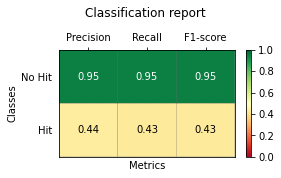

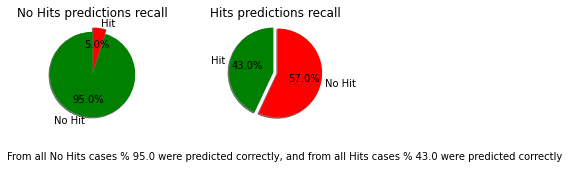

Cohen's kappa coefficient is <span style="color:green"> +0.38</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -1.08</span> below the baseline.

Hit Precision is <span style="color:green"> +0.44</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.43</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.05</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     171384     8616
Yes Hit      8484     6516



In [6]:
clf = tree.DecisionTreeClassifier()

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.4)

As we can see we have a good 'Total Accuracy' of 92 % and a good recall for false cases. The problem here is that it seems to be an overfitting given that the algorithm assert with almost the 96% false cases but when it is a true case we have around 48%. 

I decided to add two pie plots only to visualize the recall of both decisions, and in particular to show falses negatives percentage. In a real case we would try to avoid those negatives cases in order to avoid when the model predict that it will not be collision but it finally happens.

Regarding that, we can consider that the fact of having less true cases for training the model may be a problem for this investigation. However, we will try to see different approachs with the same data to deal with that.

As we can see in the Confusion Matrix we have almost 15 k true cases and we only predict almost 7k correctly.

Also this problem is repeated with 0.1, 0.2, 0.3 and 0.5 test_size.

## KNN classifier

### Search for best n neighbors number

In [7]:
#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
#fit model to data
knn_gscv.fit(X, Y)
#check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 4}

### KNN classifier with n=4

<h3>Multiple experiments average result:</h3>

Total Accuracy: %93.91
Cohen's kappa coefficient: 0.37


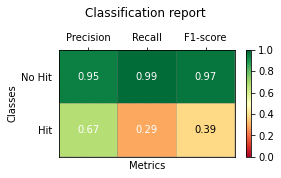

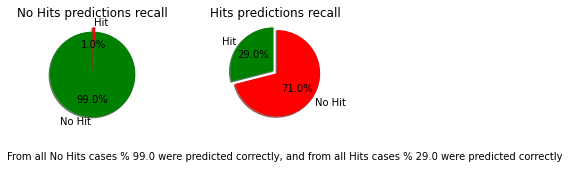

Cohen's kappa coefficient is <span style="color:green"> +0.37</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">% +1.6</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green"> +0.67</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.29</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.01</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      89982     1018
Yes Hit      4946     2054



In [8]:
knn = KNeighborsClassifier(n_neighbors = 3)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.2)

This case is a clear example of overfitting. We have a huge percentage of correct 'No Hit Predictions' but the opposite with 'Hit predictions'. The model seems to be used to predict that the driver it's not going to crash which translates into a high percentage of false negatives cases.

I used 20% of data set for testing, because performs better in this case.

## Random Forest

<h3>Multiple experiments average result:</h3>

Total Accuracy: %93.61
Cohen's kappa coefficient: 0.38


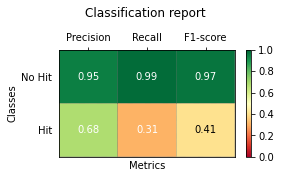

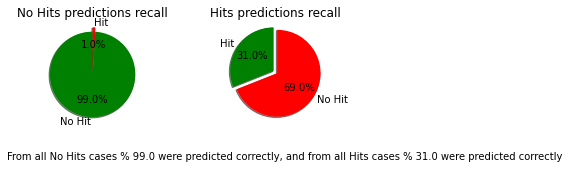

Cohen's kappa coefficient is <span style="color:green"> +0.38</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">% +1.3</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green"> +0.68</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.31</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.01</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     134197     1803
Yes Hit      7583     3417



In [20]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3)

The same problem can be seen with this model, the best recall achieved was %30 trying with different training sizes.

# Over sampling data

Now we will try increasing the numbers of true cases with different over sampling approachs:

## Random Over Sampler

In [6]:
from imblearn.over_sampling import RandomOverSampler

def random_over_sampler_split(test_size):
    ros = RandomOverSampler()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, stratify=Y)
    X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
    #X_resampled, y_resampled = X_train, y_train
    return X_resampled, X_test, y_resampled, y_test

def print_over_sampling_fuction(split_function, test_size):
    X_resampled, X_test, y_resampled, y_test = split_function(test_size)
    print_split_data_set(X_resampled, X_test, y_resampled, y_test)

In [7]:
def print_split_data_set(X_train, X_test, y_train, y_test):
    print("Training True  : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train) * 100.0)))
    print("Training False : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train) * 100.0)))
    print("")
    print("Test True      : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test) * 100.0)))
    print("Test False     : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test) * 100.0)))
    
print_over_sampling_fuction(random_over_sampler_split, 0.4)

Training True  : 270 (50.00%)
Training False : 270 (50.00%)

Test True      : 15 (7.69%)
Test False     : 180 (92.31%)


Here we can see that False cases were splitted normally and "Training True" cases are now equals to falses.

### Decision Tree

This algorith was ignore because results were worst than before (without over sampling data)

### KNN classifier

<h3>Multiple experiments average result:</h3>

Total Accuracy: %88.20
Cohen's kappa coefficient: 0.31


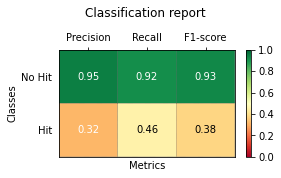

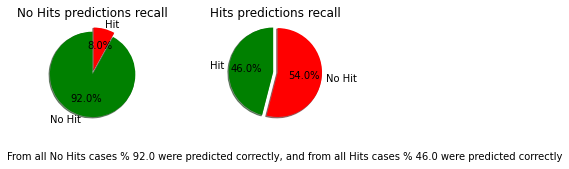

Cohen's kappa coefficient is <span style="color:green"> +0.31</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.11</span> below the baseline.

Hit Precision is <span style="color:green"> +0.32</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.46</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.08</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     165060    14940
Yes Hit      8062     6938



In [17]:
knn = KNeighborsClassifier(n_neighbors = 3)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.4, random_over_sampler_split)

With over sampling Knn seems to be better at recall, but it lose a lot of precision comparing without over sampling data.

### Random Forest

<h3>Multiple experiments average result:</h3>

Total Accuracy: %93.71
Cohen's kappa coefficient: 0.35


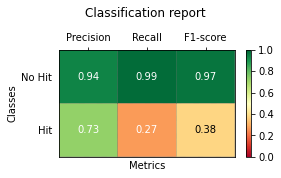

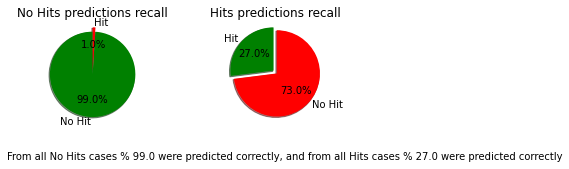

Cohen's kappa coefficient is <span style="color:green"> +0.35</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">% +1.4</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green"> +0.73</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.27</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.02</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.01</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     134787     1213
Yes Hit      8040     2960



In [13]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3, random_over_sampler_split)

For random forest there is no difference with random over sampling data.

## SMOTE

In [8]:
from imblearn.over_sampling import SMOTE, ADASYN

def smote_over_sampler_split(test_size):
    smote = SMOTE()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, stratify=Y)
    X_resampled, y_resampled = smote.fit_sample(X_train, y_train)
    return X_resampled, X_test, y_resampled, y_test

print_over_sampling_fuction(smote_over_sampler_split, 0.4)

Training True  : 270 (50.00%)
Training False : 270 (50.00%)

Test True      : 15 (7.69%)
Test False     : 180 (92.31%)


### Decision Tree

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.58
Cohen's kappa coefficient: 0.25


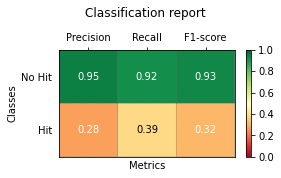

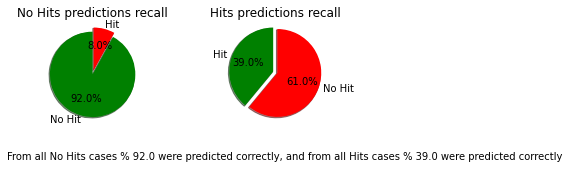

Cohen's kappa coefficient is <span style="color:green"> +0.25</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.73</span> below the baseline.

Hit Precision is <span style="color:green"> +0.28</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.39</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.08</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     124478    11522
Yes Hit      6736     4264



In [39]:
clf = tree.DecisionTreeClassifier()

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.3, smote_over_sampler_split)

Decision Tree doesn't change results with over sampling data.

### KNN classifier

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.34
Cohen's kappa coefficient: 0.24


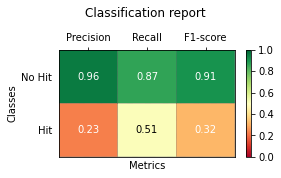

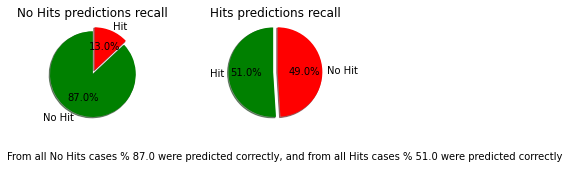

Cohen's kappa coefficient is <span style="color:green"> +0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.97</span> below the baseline.

Hit Precision is <span style="color:green"> +0.23</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.51</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.04</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      79053    11947
Yes Hit      3402     3598



In [42]:
knn = KNeighborsClassifier(n_neighbors = 3)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.2, smote_over_sampler_split)

With Smote we have better Recall but worst precision.

### Random Forest

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.57
Cohen's kappa coefficient: 0.34


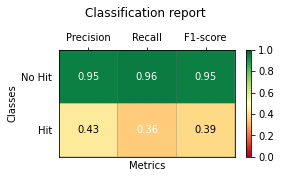

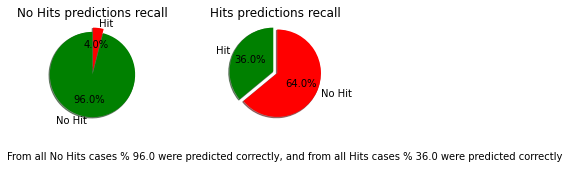

Cohen's kappa coefficient is <span style="color:green"> +0.34</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -0.74</span> below the baseline.

Hit Precision is <span style="color:green"> +0.43</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.36</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.04</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     130602     5398
Yes Hit      6994     4006



In [25]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3, smote_over_sampler_split)

This are similars results as Randon Forest without over sampling, but with a considerable worst precision. It is still possible to notice the overfitting.

## ADASYN

In [9]:
def adasyn_over_sampler_split(test_size):
    adasyn = ADASYN()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, stratify=Y)
    X_resampled, y_resampled = adasyn.fit_sample(X_train, y_train)
    return X_resampled, X_test, y_resampled, y_test

print_over_sampling_fuction(adasyn_over_sampler_split, 0.4)

Training True  : 274 (50.37%)
Training False : 270 (49.63%)

Test True      : 15 (7.69%)
Test False     : 180 (92.31%)


This oversampling it's not totally exactly when doing the true training cases. So it's not exactly 50% of each.

### Decision Tree

Ignored

### KNN classifier

<h3>Multiple experiments average result:</h3>

Total Accuracy: %80.43
Cohen's kappa coefficient: 0.22


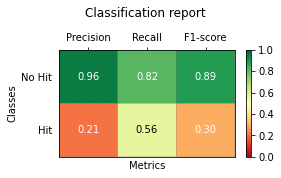

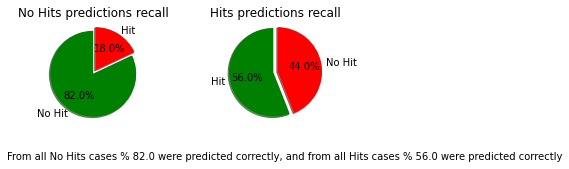

Cohen's kappa coefficient is <span style="color:green"> +0.22</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -11.88</span> below the baseline.

Hit Precision is <span style="color:green"> +0.21</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.56</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.04</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.18</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     148499    31501
Yes Hit      6662     8338



In [23]:
knn = KNeighborsClassifier(n_neighbors = 3)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.4, adasyn_over_sampler_split)

Similar recall to Smote but worst precision.

### Random Forest

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.58
Cohen's kappa coefficient: 0.33


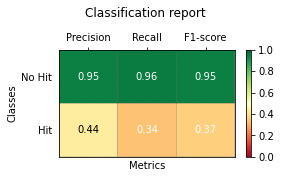

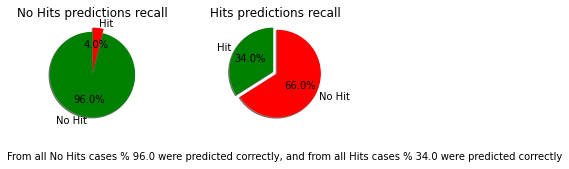

Cohen's kappa coefficient is <span style="color:green"> +0.33</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -0.73</span> below the baseline.

Hit Precision is <span style="color:green"> +0.44</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.34</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.04</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     130909     5091
Yes Hit      7280     3720



In [26]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3, adasyn_over_sampler_split)

Worst results than smote and no over sampling.

# Changing training data

I will try training the data with the same numbers of false cases and true cases but this time with less false cases:

In [10]:
def equal_cases_split(training_size_positives):
    return split_cases(training_size_positives, training_size_positives)

def double_false_cases_split(training_size_positives):
    return split_cases(training_size_positives, training_size_positives*2)

size = 3
def global_false_cases_split(training_size_positives):
    return split_cases(training_size_positives, training_size_positives*size)

def split_cases(positive_training_size, negative_training_size):
    positives = data.loc[df['hadCollision'] == 1].copy()
    negatives = data.loc[df['hadCollision'] == 0].copy()
    test_size_pos = len(positives) - positive_training_size
    test_size_neg = len(negatives) - negative_training_size

    X_train_pos, X_test_pos = train_test_split(positives, train_size=positive_training_size, test_size=test_size_pos)
    X_train_neg, X_test_neg = train_test_split(negatives, train_size=negative_training_size, test_size=test_size_neg)
    X_train_total = X_train_pos.append(X_train_neg)
    X_test_total = X_test_pos.append(X_test_neg)

    X_train_total = X_train_total.sample(frac=1).reset_index(drop=True)
    X_test_total = X_test_total.sample(frac=1).reset_index(drop=True)
    X_train = X_train_total.drop('hadCollision', axis=1) 
    y_train = X_train_total['hadCollision']

    X_test = X_test_total.drop('hadCollision', axis=1) 
    y_test = X_test_total['hadCollision']
    return X_train, X_test, y_train, y_test

def print_results_with_size(split_function, train_size_pos):
    X_train, X_test, y_train, y_test = split_function(train_size_pos)
    print("Training True  : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train) * 100.0)))
    print("Training False : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train) * 100.0)))
    print("")
    print("Test True      : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test) * 100.0)))
    print("Test False     : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test) * 100.0)))

In [11]:
print_results_with_size(equal_cases_split, 30)

Training True  : 30 (50.00%)
Training False : 30 (50.00%)

Test True      : 7 (1.64%)
Test False     : 420 (98.36%)


We have now a training set of only 60 cases with 50% hits and 50% no hits. I decided to take 30 true cases as it's almost de 80% of true cases for training.

### Decision Tree

<h3>Multiple experiments average result:</h3>

Total Accuracy: %73.11
Cohen's kappa coefficient: 0.05


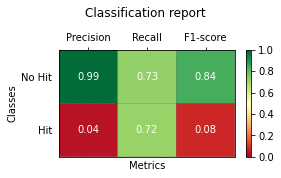

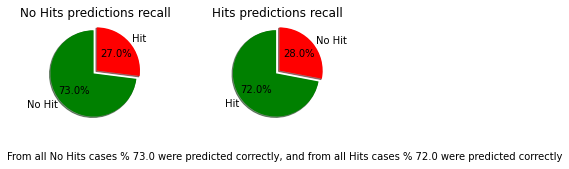

Cohen's kappa coefficient is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -19.2</span> below the baseline.

Hit Precision is <span style="color:green"> +0.04</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.72</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.27</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     307172   112828
Yes Hit      1988     5012



In [15]:
clf = tree.DecisionTreeClassifier()

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 30, equal_cases_split)

The recall is strongly increased with this approach, but now the "No hit" predictions are not as good as before and that makes a presicion for "Yes Hit"'s cases really bad due to compare 5k correct predictions with more than 100k false positives.

In [29]:
size = 4
print_results_with_size(global_false_cases_split, 20)

Training True  : 20 (20.00%)
Training False : 80 (80.00%)

Test True      : 17 (4.39%)
Test False     : 370 (95.61%)


Trying with the double of false cases for training in order to get more precision of "Yes Hit" cases, but this time taking only 20 true cases for training.

<h3>Multiple experiments average result:</h3>

Total Accuracy: %82.83
Cohen's kappa coefficient: 0.09


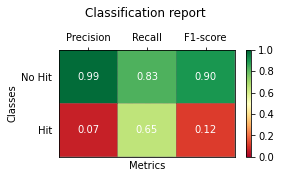

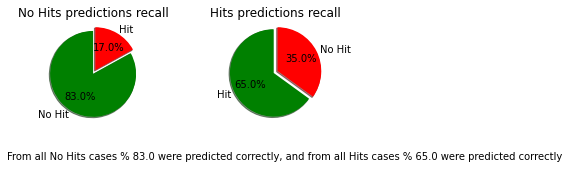

Cohen's kappa coefficient is <span style="color:green"> +0.09</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -9.48</span> below the baseline.

Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.65</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.17</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     324291    65709
Yes Hit      2475     4525



In [33]:
clf = tree.DecisionTreeClassifier()
size = 2
repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 30, global_false_cases_split)

We could increase the recall of "No Hit", which affects to "Yes Hit" precision on almost the triple, but is still low. 

### Knn

<h3>Multiple experiments average result:</h3>

Total Accuracy: %75.26
Cohen's kappa coefficient: 0.05


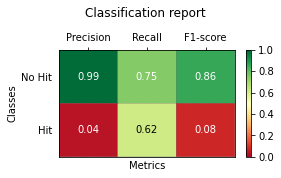

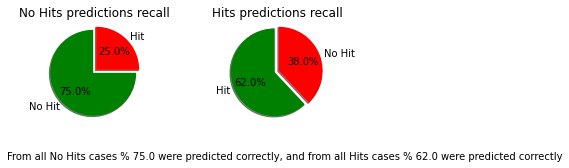

Cohen's kappa coefficient is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -17.05</span> below the baseline.

Hit Precision is <span style="color:green"> +0.04</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.62</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.25</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     316991   103009
Yes Hit      2627     4373



In [13]:
knn = KNeighborsClassifier(n_neighbors = 3)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000,  30, equal_cases_split)

Worst metrics as before

<h3>Multiple experiments average result:</h3>

Total Accuracy: %88.85
Cohen's kappa coefficient: 0.12


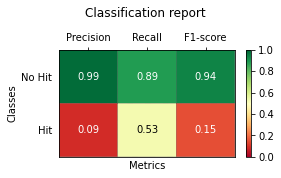

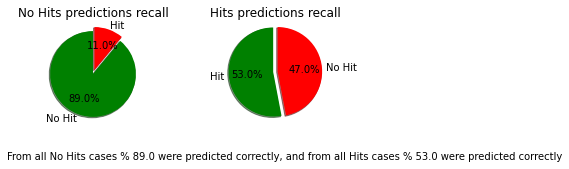

Cohen's kappa coefficient is <span style="color:green"> +0.12</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -3.46</span> below the baseline.

Hit Precision is <span style="color:green"> +0.09</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.53</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.11</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     349007    40993
Yes Hit      3261     3739



In [10]:
knn = KNeighborsClassifier(n_neighbors = 3)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000,  30, double_false_cases_split)

We recorver the recall of "No Hits" predictions but it's not enougth to have good precision of "Yes Hit"

### Random Forest

<h3>Multiple experiments average result:</h3>

Total Accuracy: %80.88
Cohen's kappa coefficient: 0.14


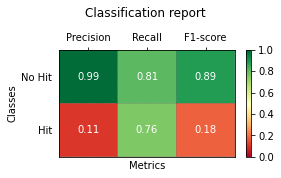

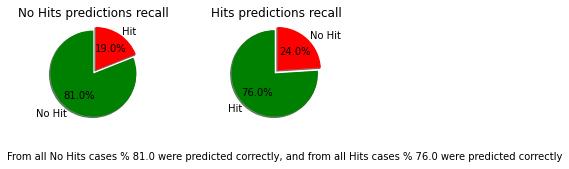

Cohen's kappa coefficient is <span style="color:green"> +0.14</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -11.43</span> below the baseline.

Hit Precision is <span style="color:green"> +0.11</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.76</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.19</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     344321    80679
Yes Hit      2861     9139



In [17]:
rf_model = RandomForestClassifier()

repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 25, equal_cases_split)

The recall it's considerable better with this configuration. However the model now seems to see a lot of cases positives than before. This doesn't affect "No hit" precision or recall, but the precision of "Yes Hit" cases it's considerable worst than before. This means we have now a lot of False Positive cases.

We can see in the confusion matrix that almost 72k cases were predicted with a collision and there were false hits. In real life this will be a problem because we would be alerting for nothing really, but in fact it is not as important as the opposite case.

<h3>Multiple experiments average result:</h3>

Total Accuracy: %90.90
Cohen's kappa coefficient: 0.32


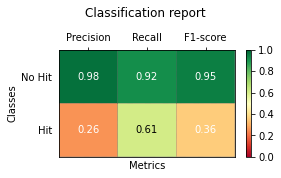

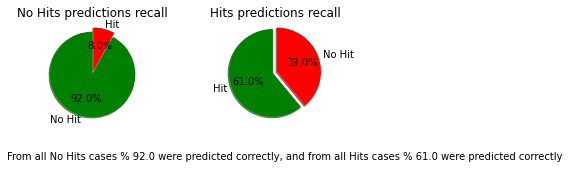

Cohen's kappa coefficient is <span style="color:green"> +0.32</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -1.41</span> below the baseline.

Hit Precision is <span style="color:green"> +0.26</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.61</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.08</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     377773    32227
Yes Hit      6612    10388



In [25]:
rf_model = RandomForestClassifier()
size = 2
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 20, global_false_cases_split)

There is an improvement with the precision of "Yes Hit" but still low. On the other hand, the recall of "Yes Hit" it's not as good as before, but in the combination of both (f1-score) this is a better configuration.

The preference on the result will depend on the weigth of those classes.

# Weights classes

## Balanced

### Decision Tree

In [18]:
#n_samples / (n_classes * np.bincount(y))

y = [0,0,0,0,0,0,0,0,0,1]

10/(2*np.bincount(y))

array([0.55555556, 5.        ])

<h3>Multiple experiments average result:</h3>

Total Accuracy: %90.22
Cohen's kappa coefficient: 0.24


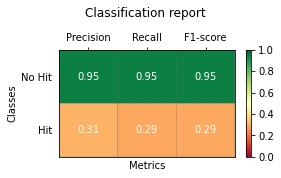

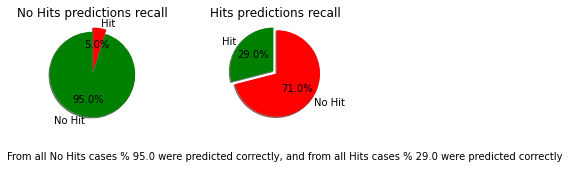

Cohen's kappa coefficient is <span style="color:green"> +0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -2.09</span> below the baseline.

Hit Precision is <span style="color:green"> +0.31</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.29</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.05</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      86374     4626
Yes Hit      4963     2037



In [11]:
clf = tree.DecisionTreeClassifier(class_weight='balanced')

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.2)

<h3>Multiple experiments average result:</h3>

Total Accuracy: %90.33
Cohen's kappa coefficient: 0.25


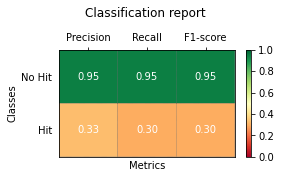

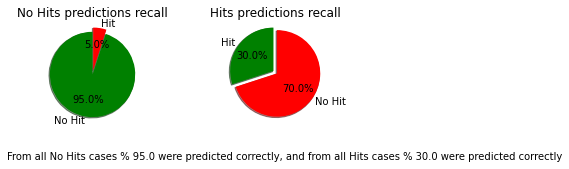

Cohen's kappa coefficient is <span style="color:green"> +0.25</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -1.98</span> below the baseline.

Hit Precision is <span style="color:green"> +0.33</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.3</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.05</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      86401     4599
Yes Hit      4880     2120



In [12]:
clf = tree.DecisionTreeClassifier(class_weight={0:1, 1:9})

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.2)

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.91
Cohen's kappa coefficient: 0.42


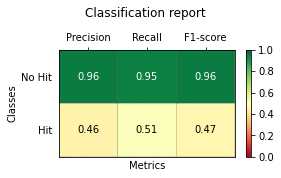

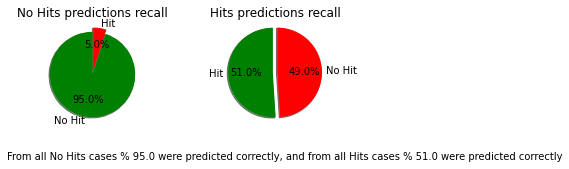

Cohen's kappa coefficient is <span style="color:green"> +0.42</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -0.4</span> below the baseline.

Hit Precision is <span style="color:green"> +0.46</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.51</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.04</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.05</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      86529     4471
Yes Hit      3459     3541



In [13]:
clf = tree.DecisionTreeClassifier(class_weight={0:9, 1:1})

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.2)

Worst than default case.

### KNN

Default value is 'uniform' or balance, so I will try with distance

<h3>Multiple experiments average result:</h3>

Total Accuracy: %93.59
Cohen's kappa coefficient: 0.35


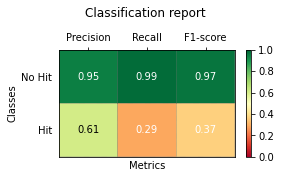

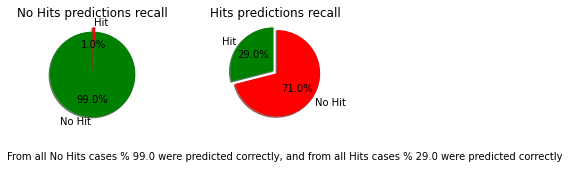

Cohen's kappa coefficient is <span style="color:green"> +0.35</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">% +1.28</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green"> +0.61</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.29</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.01</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      89711     1289
Yes Hit      4992     2008



In [10]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')

repite_model_predict_algorithm(knn.fit, knn.predict, 1000,  0.2)

Same overfitting as default case

### Random Forest

#### Balanced

<h3>Multiple experiments average result:</h3>

Total Accuracy: %93.19
Cohen's kappa coefficient: 0.18


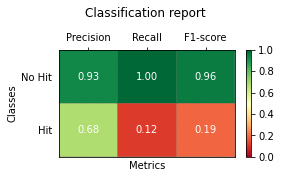

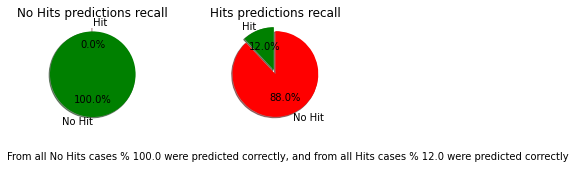

Cohen's kappa coefficient is <span style="color:green"> +0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">% +0.88</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green"> +0.68</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.12</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.01</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is same as the baseline:  1.0

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      67843      157
Yes Hit      4852      648



In [11]:
rf_model = RandomForestClassifier(class_weight="balanced")
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 0.3)

<h3>Multiple experiments average result:</h3>

Total Accuracy: %93.24
Cohen's kappa coefficient: 0.20


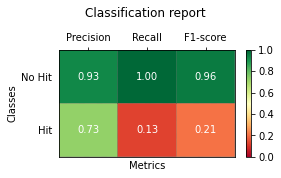

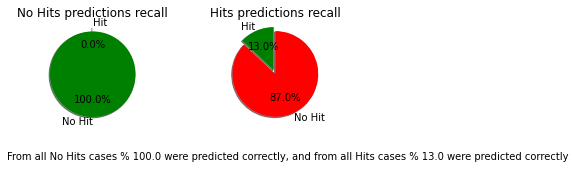

Cohen's kappa coefficient is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">% +0.93</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green"> +0.73</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.13</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.01</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is same as the baseline:  1.0

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      67813      187
Yes Hit      4782      718



In [12]:
rf_model = RandomForestClassifier(class_weight={0:1, 1:9})
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 0.3)

<h3>Multiple experiments average result:</h3>

Total Accuracy: %93.29
Cohen's kappa coefficient: 0.41


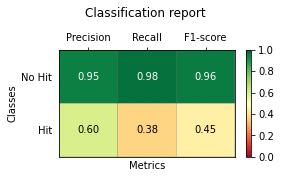

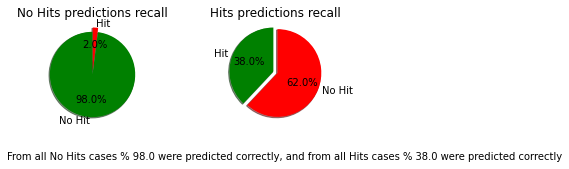

Cohen's kappa coefficient is <span style="color:green"> +0.41</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">% +0.98</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green"> +0.6</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.38</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.02</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      66508     1492
Yes Hit      3437     2063



In [13]:
rf_model = RandomForestClassifier(class_weight={0:10, 1:1})
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 0.3)

Same overfitting as default.

#### Balanced Subsample

<h3>Multiple experiments average result:</h3>

Total Accuracy: %93.19
Cohen's kappa coefficient: 0.18


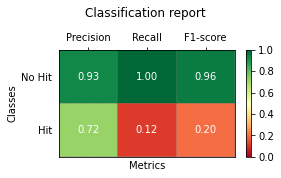

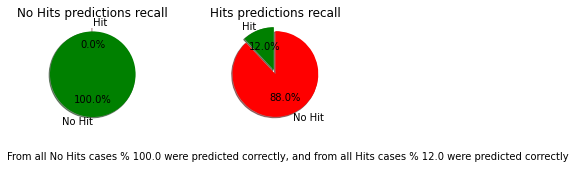

Cohen's kappa coefficient is <span style="color:green">+ 0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">+ 0.88</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green">+ 0.72</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.12</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.01</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is same as the baseline: 1.0

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     135684      316
Yes Hit      9694     1306



In [34]:
rf_model = RandomForestClassifier(class_weight="balanced_subsample")
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3)

Same overfitting as default

### Decision Tree

In [37]:
from IPython.core.display import display, Markdown

def print_header(header):
    raw_html = "<h3>"+header+"</h3>"
    display( Markdown(raw_html) )

<h3>Running: Default model-prediction</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.16
Cohen's kappa coefficient: 0.41


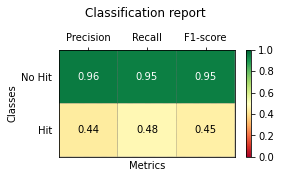

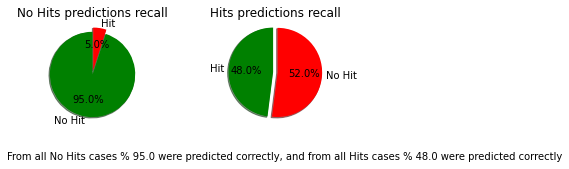

Cohen's kappa coefficient is <span style="color:green"> +0.41</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -1.15</span> below the baseline.

Hit Precision is <span style="color:green"> +0.44</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.48</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.04</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.05</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     170489     9511
Yes Hit      7725     7275



<h3>Running: Random Over Sampler</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.45
Cohen's kappa coefficient: 0.37


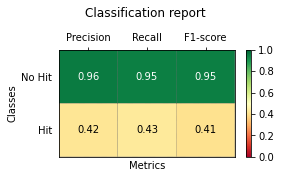

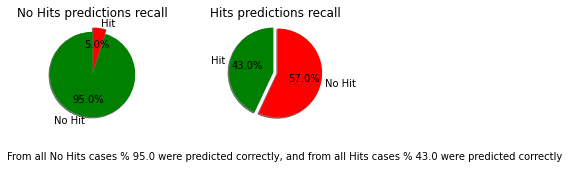

Cohen's kappa coefficient is <span style="color:green"> +0.37</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -0.86</span> below the baseline.

Hit Precision is <span style="color:green"> +0.42</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.43</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.04</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.05</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      86603     4397
Yes Hit      3981     3019



<h3>Running: SMOTE</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %88.00
Cohen's kappa coefficient: 0.36


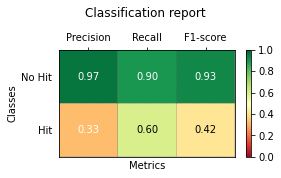

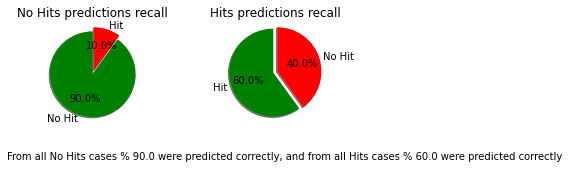

Cohen's kappa coefficient is <span style="color:green"> +0.36</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.31</span> below the baseline.

Hit Precision is <span style="color:green"> +0.33</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.6</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.1</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      82032     8968
Yes Hit      2791     4209



<h3>Running: ADASYN</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.87
Cohen's kappa coefficient: 0.36


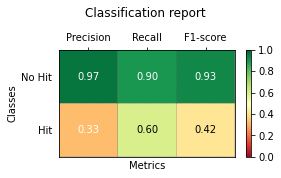

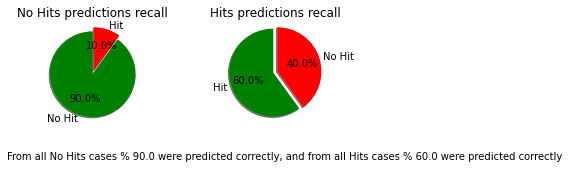

Cohen's kappa coefficient is <span style="color:green"> +0.36</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.44</span> below the baseline.

Hit Precision is <span style="color:green"> +0.33</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.6</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.1</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      81887     9113
Yes Hit      2772     4228



<h3>Running: Equal training cases</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %75.13
Cohen's kappa coefficient: 0.07


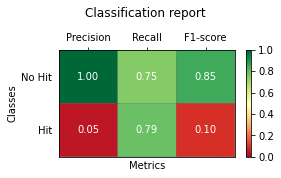

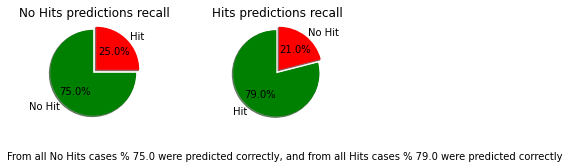

Cohen's kappa coefficient is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -17.18</span> below the baseline.

Hit Precision is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.79</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.08</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.25</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     315279   104721
Yes Hit      1485     5515



<h3>Running: Double false training cases</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %83.27
Cohen's kappa coefficient: 0.11


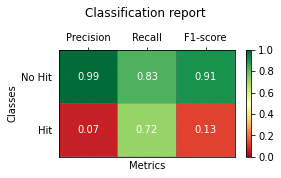

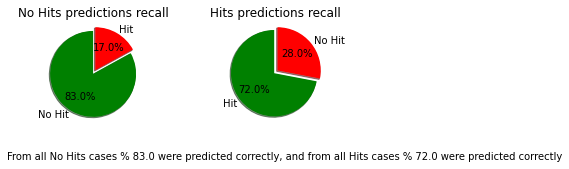

Cohen's kappa coefficient is <span style="color:green"> +0.11</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -9.04</span> below the baseline.

Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.72</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.17</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     325575    64425
Yes Hit      1984     5016



<h3>Running: Triple false training cases</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.05
Cohen's kappa coefficient: 0.14


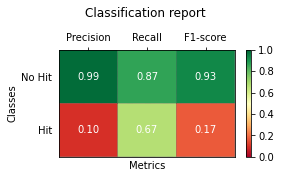

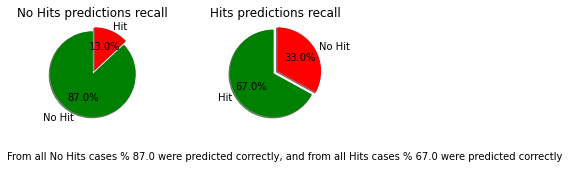

Cohen's kappa coefficient is <span style="color:green"> +0.14</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -5.26</span> below the baseline.

Hit Precision is <span style="color:green"> +0.1</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.67</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     314757    45243
Yes Hit      2296     4704



In [15]:
def run_all_models(clf):
    print_header("Running: Default model-prediction")

    repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.4)

    print_header("Running: Random Over Sampler")

    repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.2, random_over_sampler_split)

    print_header("Running: SMOTE")

    repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.2, smote_over_sampler_split)

    print_header("Running: ADASYN")

    repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.2, adasyn_over_sampler_split)

    print_header("Running: Equal training cases")

    repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 30, equal_cases_split)

    print_header("Running: Double false training cases")

    repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 30, double_false_cases_split)
    
    print_header("Running: Triple false training cases")
    size = 3
    repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 30, global_false_cases_split)
    
clf = tree.DecisionTreeClassifier(class_weight={0:10, 1:1})
run_all_models(clf)

Regarding Hits predictions recall we can see a really good performance with "Equal training cases" but again still a bad precision for this class. 

Regarding F1-score, it means seen precision and recall, we acceptable performances with Smote and Random over samplers, and with default case we have a similar performance in each component.

### Knn

I didn't find Knn class_weigths, it has a function weigth but I think is only weigths per feature:
    
    - [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.

### Random Forest

<h3>Running: Default model-prediction</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %93.30
Cohen's kappa coefficient: 0.41


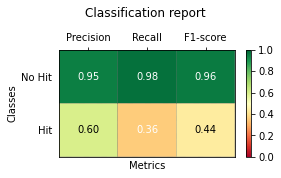

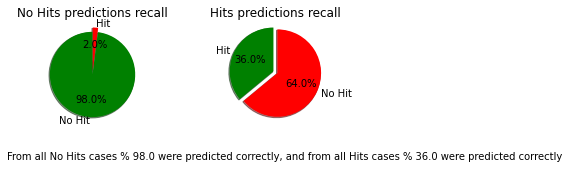

Cohen's kappa coefficient is <span style="color:green">+ 0.41</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">+ 0.99</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green">+ 0.6</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.36</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.02</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     133143     2857
Yes Hit      6989     4011



<h3>Running: Random Over Sampler</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %93.16
Cohen's kappa coefficient: 0.40


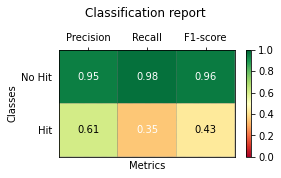

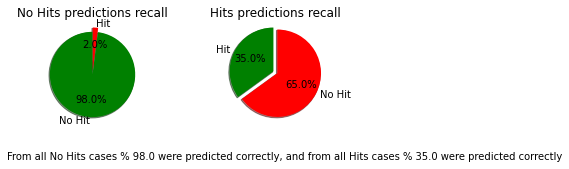

Cohen's kappa coefficient is <span style="color:green">+ 0.4</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">+ 0.85</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green">+ 0.61</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.35</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.02</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     176414     3586
Yes Hit      9755     5245



<h3>Running: SMOTE</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.47
Cohen's kappa coefficient: 0.50


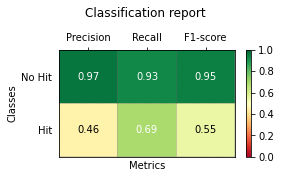

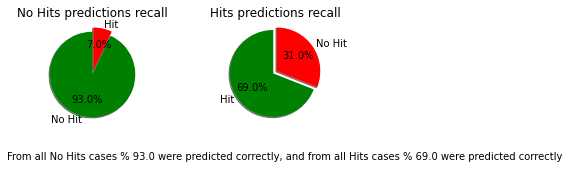

Cohen's kappa coefficient is <span style="color:green">+ 0.5</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red"> -0.84</span> below the baseline.

Hit Precision is <span style="color:green">+ 0.46</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.69</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.05</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.07</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     126870     9130
Yes Hit      3407     7593



<h3>Running: ADASYN</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.12
Cohen's kappa coefficient: 0.49


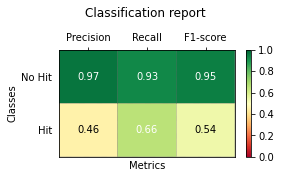

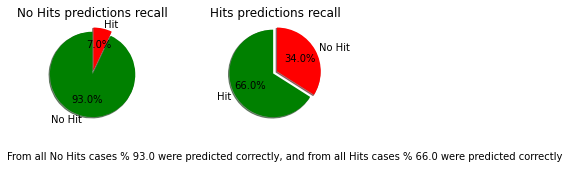

Cohen's kappa coefficient is <span style="color:green">+ 0.49</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red"> -1.19</span> below the baseline.

Hit Precision is <span style="color:green">+ 0.46</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.66</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.05</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.07</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     167741    12259
Yes Hit      5055     9945



<h3>Running: Equal training cases</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %79.23
Cohen's kappa coefficient: 0.09


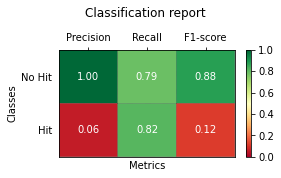

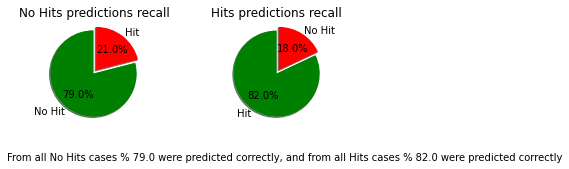

Cohen's kappa coefficient is <span style="color:green">+ 0.09</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red"> -13.08</span> below the baseline.

Hit Precision is <span style="color:green">+ 0.06</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.82</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.08</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.21</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     332571    87429
Yes Hit      1249     5751



<h3>Running: Double false training cases</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %89.28
Cohen's kappa coefficient: 0.17


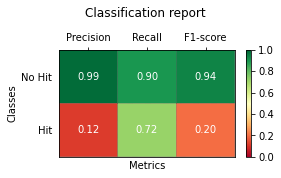

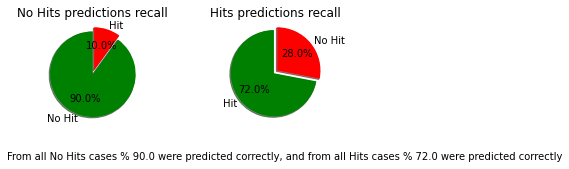

Cohen's kappa coefficient is <span style="color:green">+ 0.17</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red"> -3.03</span> below the baseline.

Hit Precision is <span style="color:green">+ 0.12</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.72</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.1</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     349437    40563
Yes Hit      1977     5023



In [37]:
def run_all_models(rf_model):
    print_header("Running: Default model-prediction")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3)
    
    print_header("Running: Random Over Sampler")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.2, random_over_sampler_split)

    print_header("Running: SMOTE")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3, smote_over_sampler_split)

    print_header("Running: ADASYN")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.4, adasyn_over_sampler_split)
    
    print_header("Running: Equal training cases")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 30, equal_cases_split)

    print_header("Running: Double false training cases")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 30, double_false_cases_split)
    
    print_header("Running: Triple false training cases")
    size = 3
    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 30, global_false_cases_split)
    
rf_model = RandomForestClassifier(class_weight={0:10, 1:1})
run_all_models(rf_model)

We can see again very good recalls for Hits predictions in Equal and Double False training cases. However regarding both variables Precision and Recall, the best prediction seems to be with SMOTE over sampling having acceptables metrics in both.

## Combine split and oversampling

In [22]:
resampler = SMOTE()
size = 2

def resampler_with_split_cases(training_size_positives):

    X_train, X_test, y_train, y_test = global_false_cases_split(training_size_positives)
    X_resampled, y_resampled = resampler.fit_sample(X_train, y_train)
    return X_resampled, X_test, y_resampled, y_test

print_results_with_size(resampler_with_split_cases, 26)

Training True  : 52 (50.00%)
Training False : 52 (50.00%)

Test True      : 11 (2.69%)
Test False     : 398 (97.31%)


<h3>Running: SMOTE splitting in size 2 with positives 30</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %83.74
Cohen's kappa coefficient: 0.12


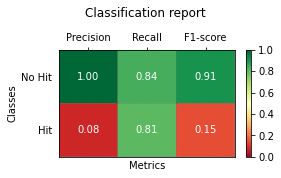

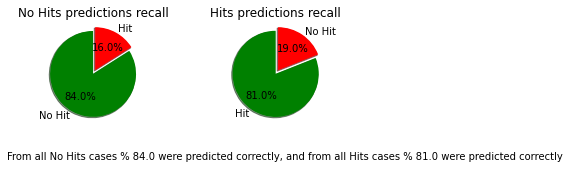

Cohen's kappa coefficient is <span style="color:green"> +0.12</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -8.57</span> below the baseline.

Hit Precision is <span style="color:green"> +0.08</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.81</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.08</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.16</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     163409    31591
Yes Hit       679     2821



<h3>Running: SMOTE splitting in size 3 with positives 30</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %86.22
Cohen's kappa coefficient: 0.16


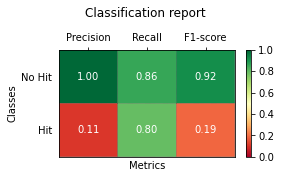

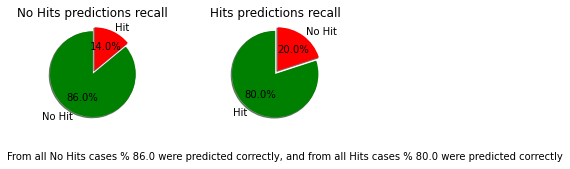

Cohen's kappa coefficient is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -6.09</span> below the baseline.

Hit Precision is <span style="color:green"> +0.11</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.8</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.08</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     155414    24586
Yes Hit       701     2799



<h3>Running: SMOTE splitting in size 4 with positives 30</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.66
Cohen's kappa coefficient: 0.18


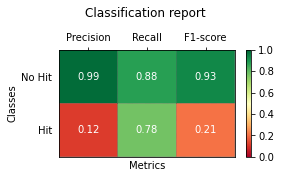

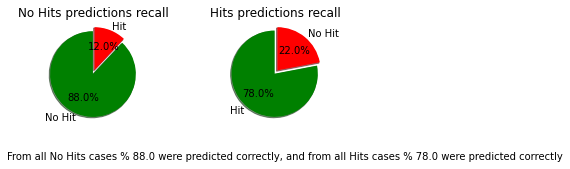

Cohen's kappa coefficient is <span style="color:green"> +0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.65</span> below the baseline.

Hit Precision is <span style="color:green"> +0.12</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.78</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.12</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     144974    20026
Yes Hit       764     2736



<h3>Running: SMOTE splitting in size 5 with positives 30</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %88.89
Cohen's kappa coefficient: 0.21


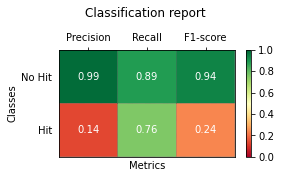

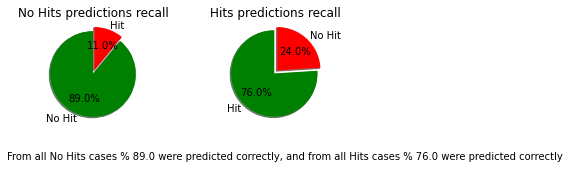

Cohen's kappa coefficient is <span style="color:green"> +0.21</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -3.42</span> below the baseline.

Hit Precision is <span style="color:green"> +0.14</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.76</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.11</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     133791    16209
Yes Hit       840     2660



<h3>Running: SMOTE splitting in size 6 with positives 30</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %89.70
Cohen's kappa coefficient: 0.25


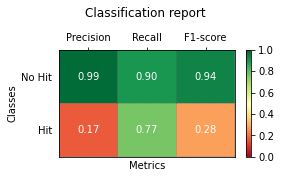

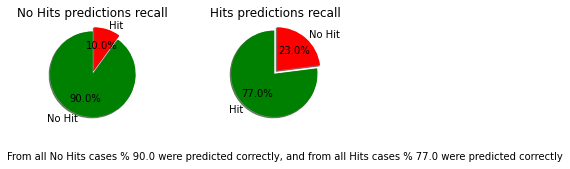

Cohen's kappa coefficient is <span style="color:green"> +0.25</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -2.61</span> below the baseline.

Hit Precision is <span style="color:green"> +0.17</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.77</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.1</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     121539    13461
Yes Hit       801     2699



<h3>Running: SMOTE splitting in size 7 with positives 30</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %90.41
Cohen's kappa coefficient: 0.28


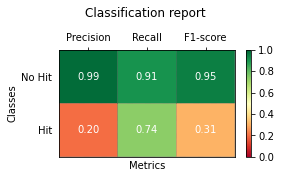

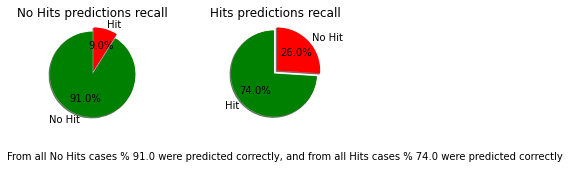

Cohen's kappa coefficient is <span style="color:green"> +0.28</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -1.9</span> below the baseline.

Hit Precision is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.74</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.09</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     109059    10941
Yes Hit       905     2595



<h3>Running: SMOTE splitting in size 8 with positives 30</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %90.94
Cohen's kappa coefficient: 0.31


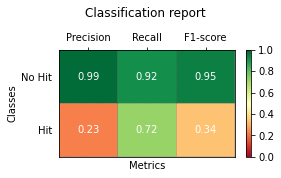

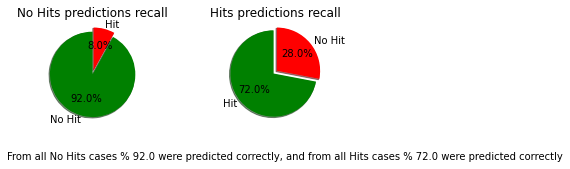

Cohen's kappa coefficient is <span style="color:green"> +0.31</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -1.37</span> below the baseline.

Hit Precision is <span style="color:green"> +0.23</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.72</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.08</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      96140     8860
Yes Hit       970     2530



<h3>Running: SMOTE splitting in size 9 with positives 30</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.13
Cohen's kappa coefficient: 0.35


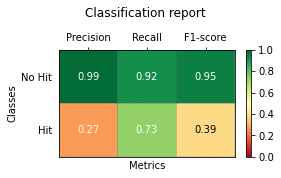

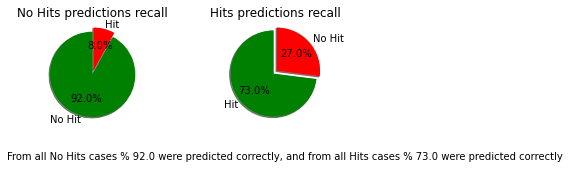

Cohen's kappa coefficient is <span style="color:green"> +0.35</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -1.18</span> below the baseline.

Hit Precision is <span style="color:green"> +0.27</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.73</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.08</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      82650     7350
Yes Hit       946     2554



<h3>Running: SMOTE splitting in size 10 with positives 30</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.52
Cohen's kappa coefficient: 0.38


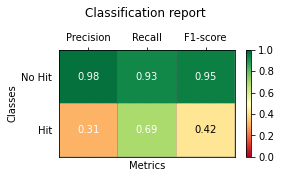

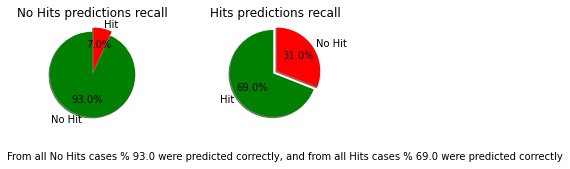

Cohen's kappa coefficient is <span style="color:green"> +0.38</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -0.79</span> below the baseline.

Hit Precision is <span style="color:green"> +0.31</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.69</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.07</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      69433     5567
Yes Hit      1091     2409



<h3>Running: SMOTE splitting in size 11 with positives 30</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.66
Cohen's kappa coefficient: 0.44


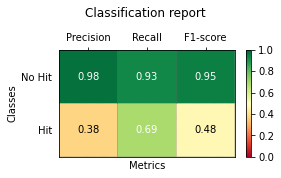

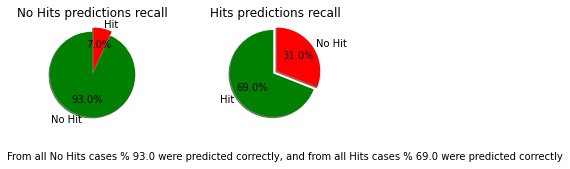

Cohen's kappa coefficient is <span style="color:green"> +0.44</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -0.65</span> below the baseline.

Hit Precision is <span style="color:green"> +0.38</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.69</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.07</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      55792     4208
Yes Hit      1089     2411



In [41]:
resampler = SMOTE()
positives = 30
for i in range(2,12):
    rf_model = RandomForestClassifier(class_weight={0:10, 1:1})

    size = i
    
    print_header("Running: SMOTE splitting in size " + str(size) + " with positives " + str(positives) )


    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, positives, resampler_with_split_cases)

<h3>Running: ADASYN splitting in size 2 with positives 30</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %82.47
Cohen's kappa coefficient: 0.12


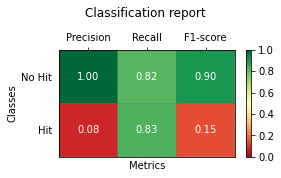

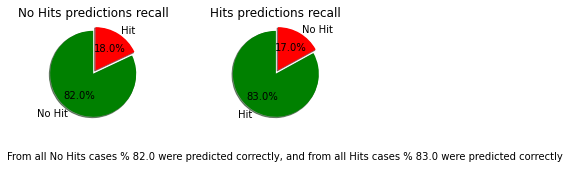

Cohen's kappa coefficient is <span style="color:green"> +0.12</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -9.84</span> below the baseline.

Hit Precision is <span style="color:green"> +0.08</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.83</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.08</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.18</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     160801    34199
Yes Hit       600     2900



<h3>Running: ADASYN splitting in size 3 with positives 30</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.11
Cohen's kappa coefficient: 0.14


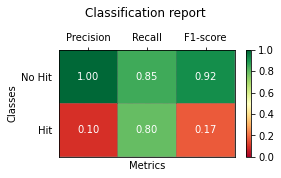

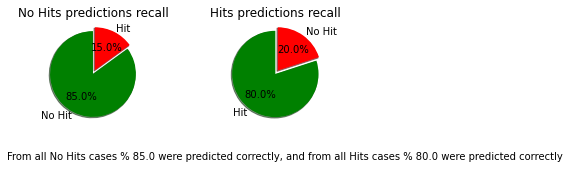

Cohen's kappa coefficient is <span style="color:green"> +0.14</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.2</span> below the baseline.

Hit Precision is <span style="color:green"> +0.1</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.8</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.08</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.15</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     153384    26616
Yes Hit       701     2799



<h3>Running: ADASYN splitting in size 4 with positives 30</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %86.45
Cohen's kappa coefficient: 0.17


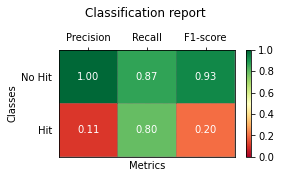

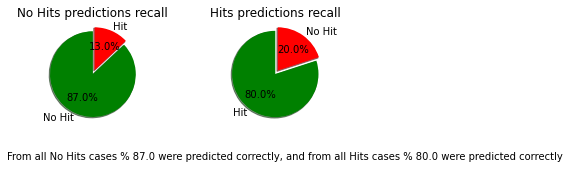

Cohen's kappa coefficient is <span style="color:green"> +0.17</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -5.86</span> below the baseline.

Hit Precision is <span style="color:green"> +0.11</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.8</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.08</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     142882    22118
Yes Hit       712     2788



<h3>Running: ADASYN splitting in size 5 with positives 30</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %88.30
Cohen's kappa coefficient: 0.20


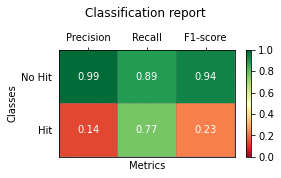

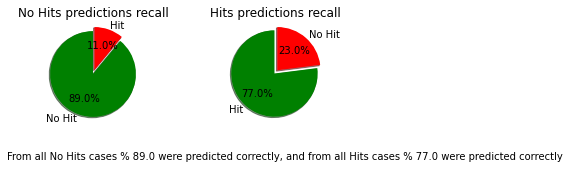

Cohen's kappa coefficient is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.01</span> below the baseline.

Hit Precision is <span style="color:green"> +0.14</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.77</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.11</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     132840    17160
Yes Hit       806     2694



<h3>Running: ADASYN splitting in size 6 with positives 30</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %89.03
Cohen's kappa coefficient: 0.23


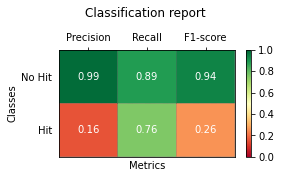

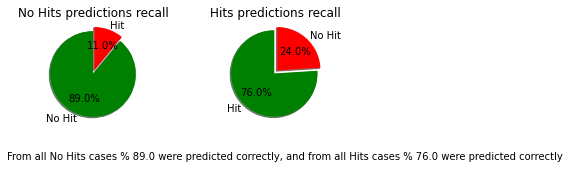

Cohen's kappa coefficient is <span style="color:green"> +0.23</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -3.28</span> below the baseline.

Hit Precision is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.76</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.11</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     120646    14354
Yes Hit       841     2659



<h3>Running: ADASYN splitting in size 7 with positives 30</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %89.59
Cohen's kappa coefficient: 0.26


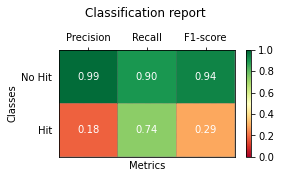

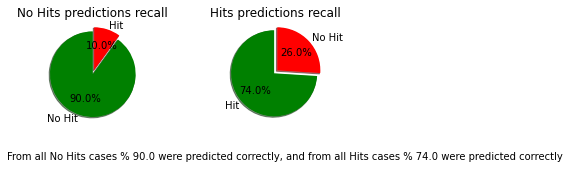

Cohen's kappa coefficient is <span style="color:green"> +0.26</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -2.72</span> below the baseline.

Hit Precision is <span style="color:green"> +0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.74</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.1</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     108056    11944
Yes Hit       910     2590



<h3>Running: ADASYN splitting in size 8 with positives 30</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %90.44
Cohen's kappa coefficient: 0.30


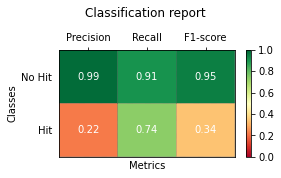

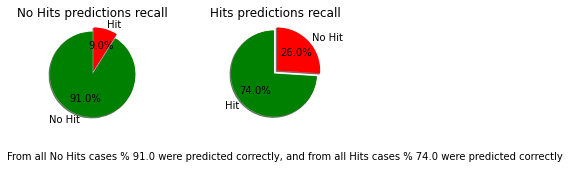

Cohen's kappa coefficient is <span style="color:green"> +0.3</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -1.87</span> below the baseline.

Hit Precision is <span style="color:green"> +0.22</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.74</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.09</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      95538     9462
Yes Hit       909     2591



<h3>Running: ADASYN splitting in size 9 with positives 30</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %90.84
Cohen's kappa coefficient: 0.34


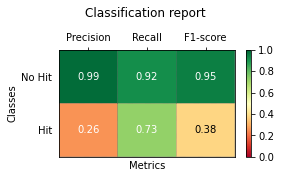

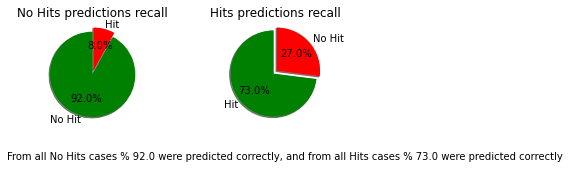

Cohen's kappa coefficient is <span style="color:green"> +0.34</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -1.47</span> below the baseline.

Hit Precision is <span style="color:green"> +0.26</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.73</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.08</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      82370     7630
Yes Hit       931     2569



<h3>Running: ADASYN splitting in size 10 with positives 30</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.27
Cohen's kappa coefficient: 0.38


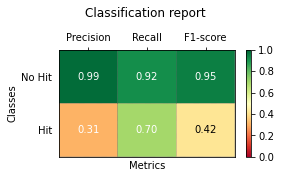

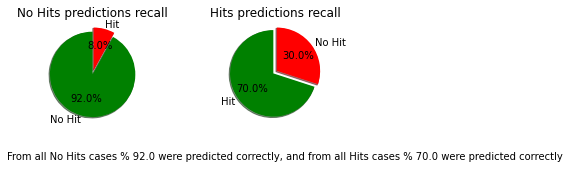

Cohen's kappa coefficient is <span style="color:green"> +0.38</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -1.04</span> below the baseline.

Hit Precision is <span style="color:green"> +0.31</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.7</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.08</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      69182     5818
Yes Hit      1035     2465



<h3>Running: ADASYN splitting in size 11 with positives 30</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.21
Cohen's kappa coefficient: 0.42


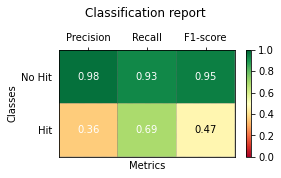

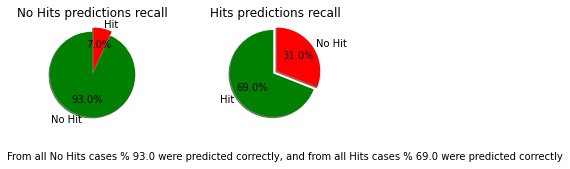

Cohen's kappa coefficient is <span style="color:green"> +0.42</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -1.1</span> below the baseline.

Hit Precision is <span style="color:green"> +0.36</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.69</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.07</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      55517     4483
Yes Hit      1097     2403



In [42]:
resampler = ADASYN()
positives = 30

for i in range(2,12):
    rf_model = RandomForestClassifier(class_weight={0:10, 1:1})

    size = i
    
    print_header("Running: ADASYN splitting in size " + str(size) + " with positives " + str(positives) )


    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, positives, resampler_with_split_cases)

<h3>Running: SMOTE splitting in size 2 with positives 26</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %83.40
Cohen's kappa coefficient: 0.17


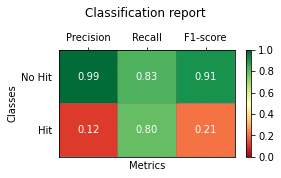

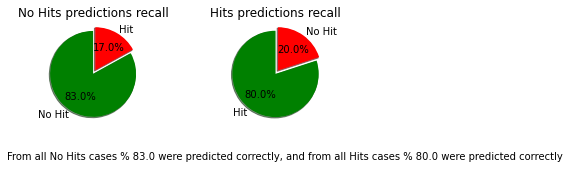

Cohen's kappa coefficient is <span style="color:green"> +0.17</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -8.91</span> below the baseline.

Hit Precision is <span style="color:green"> +0.12</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.8</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.17</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     166148    32852
Yes Hit      1102     4398



<h3>Running: SMOTE splitting in size 3 with positives 26</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %86.06
Cohen's kappa coefficient: 0.21


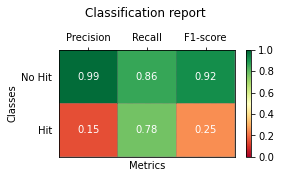

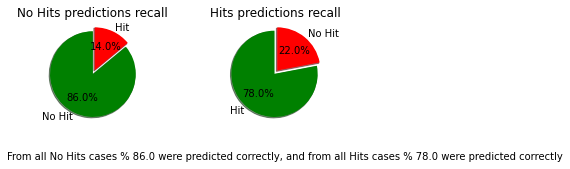

Cohen's kappa coefficient is <span style="color:green"> +0.21</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -6.25</span> below the baseline.

Hit Precision is <span style="color:green"> +0.15</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.78</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     160499    25501
Yes Hit      1192     4308



<h3>Running: SMOTE splitting in size 4 with positives 26</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.56
Cohen's kappa coefficient: 0.24


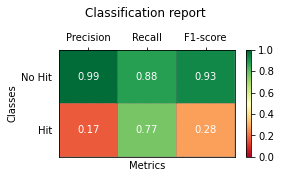

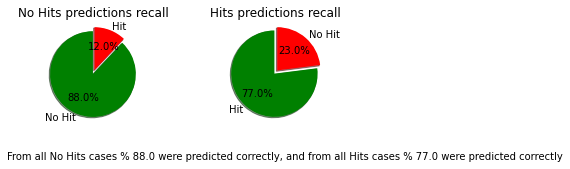

Cohen's kappa coefficient is <span style="color:green"> +0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.75</span> below the baseline.

Hit Precision is <span style="color:green"> +0.17</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.77</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.12</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     152068    20932
Yes Hit      1281     4219



<h3>Running: SMOTE splitting in size 5 with positives 26</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %88.56
Cohen's kappa coefficient: 0.27


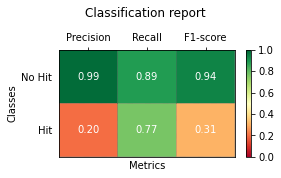

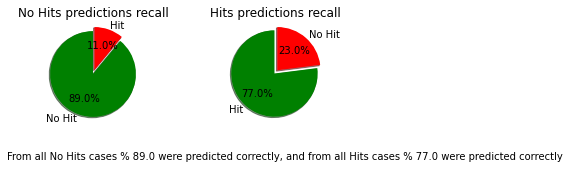

Cohen's kappa coefficient is <span style="color:green"> +0.27</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -3.75</span> below the baseline.

Hit Precision is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.77</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.11</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     142360    17640
Yes Hit      1287     4213



<h3>Running: SMOTE splitting in size 6 with positives 26</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %89.43
Cohen's kappa coefficient: 0.30


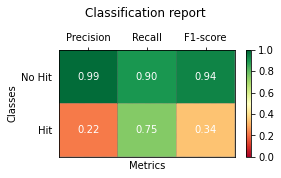

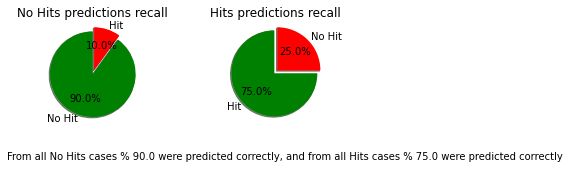

Cohen's kappa coefficient is <span style="color:green"> +0.3</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -2.88</span> below the baseline.

Hit Precision is <span style="color:green"> +0.22</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.75</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.1</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     132278    14722
Yes Hit      1399     4101



<h3>Running: SMOTE splitting in size 7 with positives 26</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %90.01
Cohen's kappa coefficient: 0.33


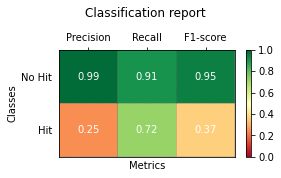

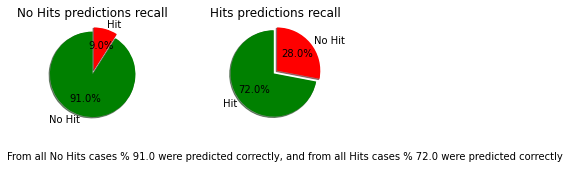

Cohen's kappa coefficient is <span style="color:green"> +0.33</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -2.3</span> below the baseline.

Hit Precision is <span style="color:green"> +0.25</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.72</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.09</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     121585    12415
Yes Hit      1520     3980



<h3>Running: SMOTE splitting in size 8 with positives 26</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %90.63
Cohen's kappa coefficient: 0.36


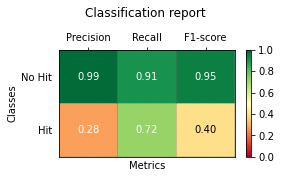

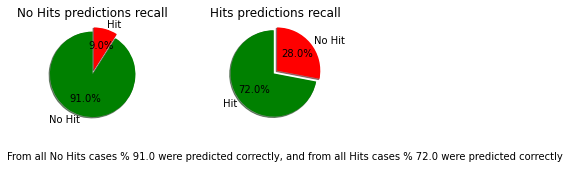

Cohen's kappa coefficient is <span style="color:green"> +0.36</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -1.68</span> below the baseline.

Hit Precision is <span style="color:green"> +0.28</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.72</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.09</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     110691    10309
Yes Hit      1542     3958



<h3>Running: SMOTE splitting in size 9 with positives 26</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %90.90
Cohen's kappa coefficient: 0.39


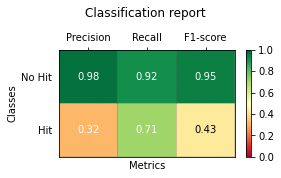

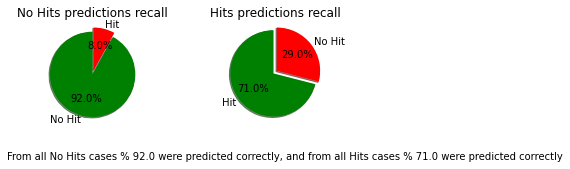

Cohen's kappa coefficient is <span style="color:green"> +0.39</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -1.41</span> below the baseline.

Hit Precision is <span style="color:green"> +0.32</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.71</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.08</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      99244     8756
Yes Hit      1575     3925



<h3>Running: SMOTE splitting in size 10 with positives 26</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.33
Cohen's kappa coefficient: 0.43


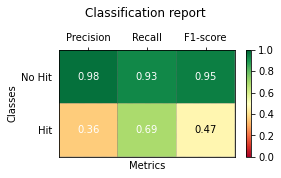

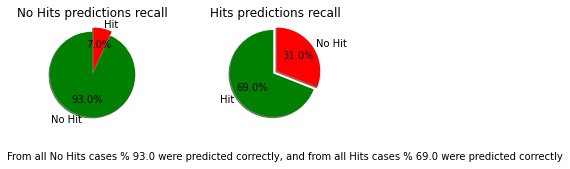

Cohen's kappa coefficient is <span style="color:green"> +0.43</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -0.98</span> below the baseline.

Hit Precision is <span style="color:green"> +0.36</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.69</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.07</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      87998     7002
Yes Hit      1712     3788



<h3>Running: SMOTE splitting in size 11 with positives 26</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.22
Cohen's kappa coefficient: 0.45


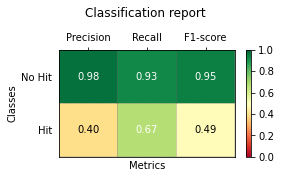

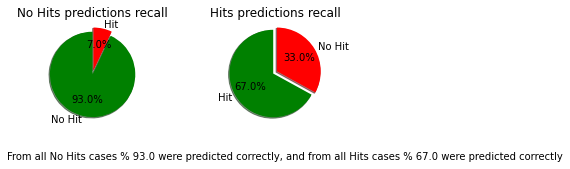

Cohen's kappa coefficient is <span style="color:green"> +0.45</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -1.09</span> below the baseline.

Hit Precision is <span style="color:green"> +0.4</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.67</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.07</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      76109     5891
Yes Hit      1789     3711



In [43]:
resampler = SMOTE()
positives = 26
for i in range(2,12):
    rf_model = RandomForestClassifier(class_weight={0:10, 1:1})

    size = i
    
    print_header("Running: SMOTE splitting in size " + str(size) + " with positives " + str(positives) )


    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, positives, resampler_with_split_cases)

<h3>Running: ADASYN splitting in size 2 with positives 26</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %82.30
Cohen's kappa coefficient: 0.16


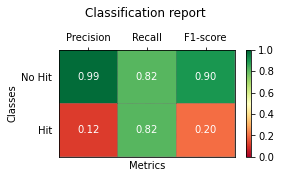

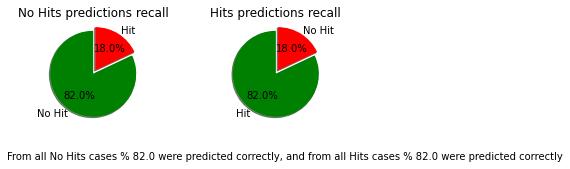

Cohen's kappa coefficient is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -10.01</span> below the baseline.

Hit Precision is <span style="color:green"> +0.12</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.82</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.18</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     163815    35185
Yes Hit      1006     4494



<h3>Running: ADASYN splitting in size 3 with positives 26</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.86
Cohen's kappa coefficient: 0.20


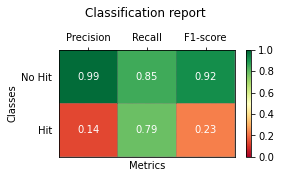

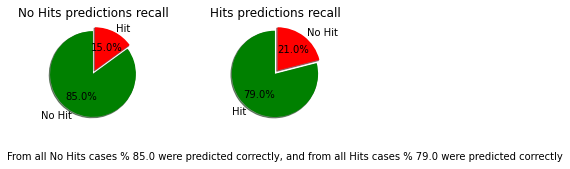

Cohen's kappa coefficient is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.45</span> below the baseline.

Hit Precision is <span style="color:green"> +0.14</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.79</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.15</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     158152    27848
Yes Hit      1138     4362



<h3>Running: ADASYN splitting in size 4 with positives 26</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %86.55
Cohen's kappa coefficient: 0.23


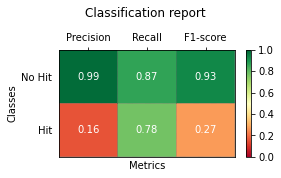

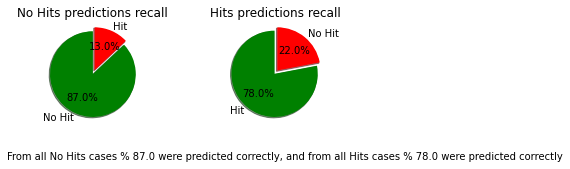

Cohen's kappa coefficient is <span style="color:green"> +0.23</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -5.76</span> below the baseline.

Hit Precision is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.78</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     150206    22794
Yes Hit      1211     4289



<h3>Running: ADASYN splitting in size 5 with positives 26</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.94
Cohen's kappa coefficient: 0.27


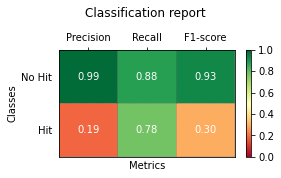

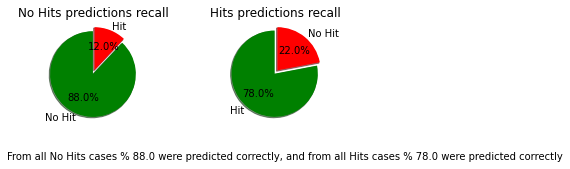

Cohen's kappa coefficient is <span style="color:green"> +0.27</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.37</span> below the baseline.

Hit Precision is <span style="color:green"> +0.19</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.78</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.12</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     141273    18727
Yes Hit      1231     4269



<h3>Running: ADASYN splitting in size 6 with positives 26</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %88.72
Cohen's kappa coefficient: 0.29


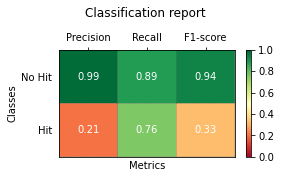

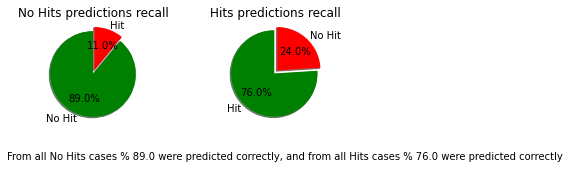

Cohen's kappa coefficient is <span style="color:green"> +0.29</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -3.59</span> below the baseline.

Hit Precision is <span style="color:green"> +0.21</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.76</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.11</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     131112    15888
Yes Hit      1312     4188



<h3>Running: ADASYN splitting in size 7 with positives 26</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %89.56
Cohen's kappa coefficient: 0.32


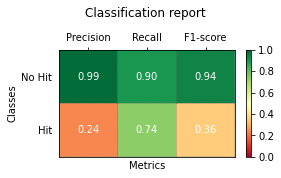

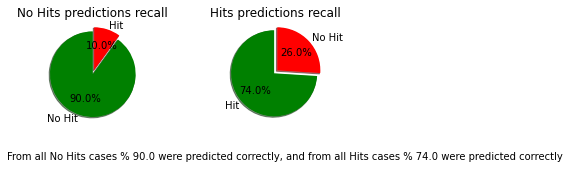

Cohen's kappa coefficient is <span style="color:green"> +0.32</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -2.75</span> below the baseline.

Hit Precision is <span style="color:green"> +0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.74</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.1</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     120878    13122
Yes Hit      1440     4060



<h3>Running: ADASYN splitting in size 8 with positives 26</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %89.90
Cohen's kappa coefficient: 0.35


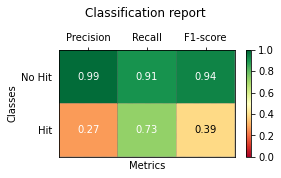

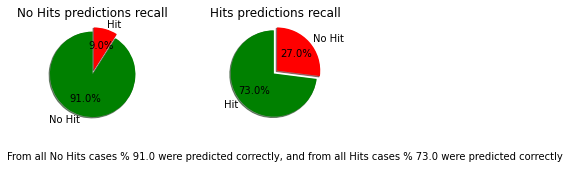

Cohen's kappa coefficient is <span style="color:green"> +0.35</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -2.41</span> below the baseline.

Hit Precision is <span style="color:green"> +0.27</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.73</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.09</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     109731    11269
Yes Hit      1503     3997



<h3>Running: ADASYN splitting in size 9 with positives 26</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %90.42
Cohen's kappa coefficient: 0.38


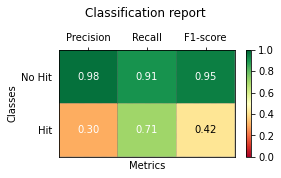

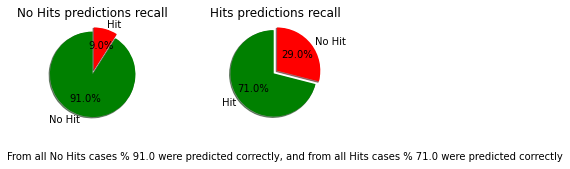

Cohen's kappa coefficient is <span style="color:green"> +0.38</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -1.89</span> below the baseline.

Hit Precision is <span style="color:green"> +0.3</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.71</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.09</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      98724     9276
Yes Hit      1599     3901



<h3>Running: ADASYN splitting in size 10 with positives 26</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %90.80
Cohen's kappa coefficient: 0.41


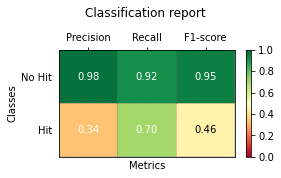

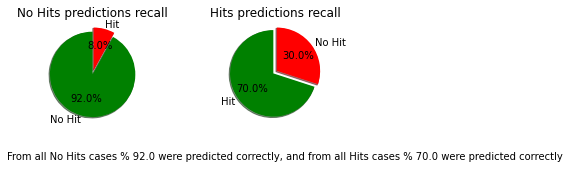

Cohen's kappa coefficient is <span style="color:green"> +0.41</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -1.51</span> below the baseline.

Hit Precision is <span style="color:green"> +0.34</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.7</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.08</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      87410     7590
Yes Hit      1655     3845



<h3>Running: ADASYN splitting in size 11 with positives 26</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.09
Cohen's kappa coefficient: 0.45


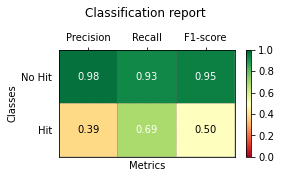

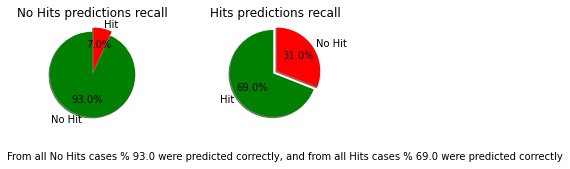

Cohen's kappa coefficient is <span style="color:green"> +0.45</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -1.22</span> below the baseline.

Hit Precision is <span style="color:green"> +0.39</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.69</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.07</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      75911     6089
Yes Hit      1704     3796



In [44]:
resampler = ADASYN()
positives = 26

for i in range(2,12):
    rf_model = RandomForestClassifier(class_weight={0:10, 1:1})

    size = i
    
    print_header("Running: ADASYN splitting in size " + str(size) + " with positives " + str(positives) )


    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, positives, resampler_with_split_cases)